# tensorflow使用LSTM对mnist数据集分类

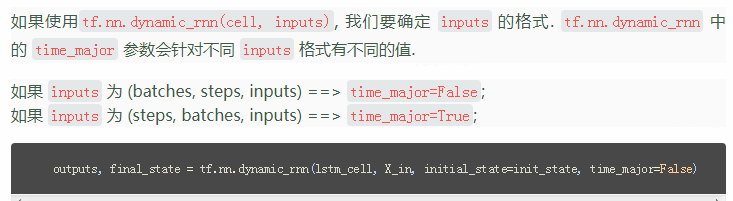

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import sys

In [2]:
#读取mnist数据集
mnist = input_data.read_data_sets('MNIST_DATA',one_hot=True)

Extracting MNIST_DATA\train-images-idx3-ubyte.gz
Extracting MNIST_DATA\train-labels-idx1-ubyte.gz
Extracting MNIST_DATA\t10k-images-idx3-ubyte.gz
Extracting MNIST_DATA\t10k-labels-idx1-ubyte.gz


In [209]:
train_graph = tf.Graph()
with train_graph.as_default(): 
    #设置超参数
    learningrate = 0.001
    n_inputs = 28
    n_steps = 28
    batch_size = 128
    batch_loops = 100000
    n_units = 128
    n_layers = 1
    n_classes = 10



In [210]:
#初始化输入输出
with train_graph.as_default(): 
    inputs = tf.placeholder(tf.float32,[None,n_steps,n_inputs])
    labels = tf.placeholder(tf.float32,[None,n_classes])

In [211]:
#定义权重和偏置
with train_graph.as_default(): 
    weights={
        'in':tf.Variable(tf.random_normal([n_inputs,n_units])),
        'out':tf.Variable(tf.random_normal([n_units,n_classes]))
    }
    biasis={
        'in':tf.Variable(tf.zeros([n_units])),
        'out':tf.Variable(tf.zeros([n_classes]))
    }

In [212]:
#定义神经网络单元
def rnn_unit(inputs,weights,biasis):
    #输入层到隐藏层，使用linear
    #==>128batch*28n_steps,28n_inputs
    inputs = tf.reshape(inputs,[-1,n_inputs])
    print(inputs.shape)
    print(weights['in'].get_shape().as_list())
    #==>128batch*28n_steps,128n_units
    inputs_h = tf.matmul(inputs,weights['in']) + biasis['in']
    #==>128batch,28n_steps,128n_units
    #inputs_ = tf.reshape(inputs_h,[n_steps,-1,n_units])
    #inputs_ = tf.reshape(inputs_h,[-1,n_steps,n_units])
    """
    tf.split()返回的是一个list吗
    """
    inputs_ = tf.split(inputs_h, n_steps, axis=0) 
    inputs_ = tf.reshape(inputs_,[n_steps,-1,n_units])
    print(tf.shape(inputs_))
    #隐藏层
    def lstm_cell():
        lstm = tf.contrib.rnn.BasicLSTMCell(n_units,state_is_tuple=True)
        return lstm
    cell = tf.contrib.rnn.MultiRNNCell([lstm_cell() for _ in range(n_layers)])
    initial_state = cell.zero_state(batch_size,dtype = tf.float32)
    
    outputs,final_state = tf.nn.dynamic_rnn(cell,inputs_,dtype = tf.float32)
    print(outputs.get_shape().as_list())
    #print(final_state)
    print('output[-1]',outputs[-1].get_shape().as_list())
    #输出层
    logits = tf.matmul(outputs[-1],weights['out']) + biasis['out']
    print(logits.get_shape().as_list())
    return logits


In [213]:
with train_graph.as_default(): 
    #cost
    logits = rnn_unit(inputs,weights,biasis)
    loss = tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels = labels)
    #print(loss)
    cost = tf.reduce_mean(loss)
    optimizer = tf.train.AdamOptimizer().minimize(cost)

    #accurancy
    correct = tf.equal(tf.argmax(logits,1),tf.argmax(labels,1))
    acuaracy = tf.reduce_mean(tf.cast(correct,tf.float32))

(?, 28)
[28, 128]
Tensor("Shape:0", shape=(3,), dtype=int32)
[28, None, 128]
output[-1] [None, 128]
[None, 10]


In [214]:
with train_graph.as_default(): 
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        step = 1
        while step*batch_size < batch_loops:
            batch_x,batch_y = mnist.train.next_batch(batch_size)
            batch_x = batch_x.reshape((batch_size,n_steps,n_inputs))
            #print(batch_x.shape,batch_y.shape)
            feed = {inputs:batch_x,labels:batch_y}
            sess.run(optimizer,feed_dict= feed)

            if step%10 == 0:
                acc = sess.run(acuaracy,feed_dict=feed)
                Loss = sess.run(cost,feed_dict=feed)
                print("Iter",str(step*batch_size),",Minibatch Loss = ","{:.6f}".format(Loss),",Accuracy = ","{:.5f}".format(acc))
            step = step+1

Iter 1280 ,Minibatch Loss =  3.058977 ,Accuracy =  0.11719
Iter 2560 ,Minibatch Loss =  2.803039 ,Accuracy =  0.10156
Iter 3840 ,Minibatch Loss =  2.547756 ,Accuracy =  0.10156
Iter 5120 ,Minibatch Loss =  2.492746 ,Accuracy =  0.12500
Iter 6400 ,Minibatch Loss =  2.453977 ,Accuracy =  0.08594
Iter 7680 ,Minibatch Loss =  2.473840 ,Accuracy =  0.13281


KeyboardInterrupt: 